In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from itertools import combinations
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import importlib.util

In [2]:
print(sys.path)

['C:\\Users\\Mi\\Documents\\Diploma\\GMDH\\examples', 'c:\\users\\mi\\appdata\\local\\programs\\python\\python38\\python38.zip', 'c:\\users\\mi\\appdata\\local\\programs\\python\\python38\\DLLs', 'c:\\users\\mi\\appdata\\local\\programs\\python\\python38\\lib', 'c:\\users\\mi\\appdata\\local\\programs\\python\\python38', '', 'c:\\users\\mi\\appdata\\local\\programs\\python\\python38\\lib\\site-packages', 'c:\\users\\mi\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\win32', 'c:\\users\\mi\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\win32\\lib', 'c:\\users\\mi\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\Pythonwin']


In [3]:
sys.path.insert(1, "C:/Users/Mi/Documents/Diploma/GMDH/build/Release")

In [4]:
import gmdhpy as gm

In [5]:
dir(gm)

['COMBI',
 'Criterion',
 'CriterionType',
 'GMDH',
 'MIA',
 'MULTI',
 'ParallelCriterion',
 'PolynomialType',
 'SequentialCriterion',
 'Solver',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'convertToTimeSeries',
 'splitData',
 'splitted_data']

In [5]:
def data_preparation(x, lags, validate_size, test_size=0):
    #print("x: ", x)
    x_data = list()
    y_data = list()
    for i in range(len(x) - lags):
        x_data.append(list(x.values[i:i+lags]))
        y_data.append(x.values[i+lags])
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=validate_size, shuffle=False)
    x_train = np.array(x_train)
    x_val = np.array(x_val)
    #print("x_train:\n", x_train)
    #print("y_train:\n", y_train)
    #print("x_val:\n", x_val)
    #print("y_val:\n", y_val)
    if test_size > 0:
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size, shuffle=False)
        x_train = np.array(x_train)
        x_test = np.array(x_test)
        return x_train, y_train, x_test, y_test, x_val, y_val
    else:
        return x_train, y_train, x_val, y_val

def print_polynom(polynom, coeffs):
    best_polynom_str = "y ="
    for i in range(len(polynom)):
        if coeffs[i] > 0:
            if i > 0:
                best_polynom_str += " + "
            else:
                best_polynom_str += " "
        else:
            best_polynom_str += " - "
        best_polynom_str += str(abs(coeffs[i]))
        if i != len(coeffs) - 1:
            best_polynom_str += "*x" + str(polynom[i] + 1)
    print(best_polynom_str)

In [6]:
def regression(x, lags, validate_size):
    x_train, y_train, x_val, y_val = data_preparation(x, lags, validate_size)
    lr = LinearRegression(n_jobs=-1)
    lr.fit(x_train, y_train)
    coeffs = list(lr.coef_)
    coeffs.append(lr.intercept_)
    coeffs = [round(coeff, 6) for coeff in coeffs]
    y_pred = lr.predict(x_val)
    error = round(mean_squared_error(y_pred, y_val), 6)
    print_polynom(range(lags + 1), coeffs)
    return y_pred

In [7]:
def regression_combi(x, lags, validate_size, test_size):
    x_train, y_train, x_test, y_test, x_val, y_val = data_preparation(x, lags, validate_size, test_size)
    lr = LinearRegression(n_jobs=-1)
    last_error = 100000000000000
    best_coeffs = []
    best_polynom = []
    for level in range(1, x_train.shape[1] + 1):
        errors = []
        for comb in combinations(range(x_train.shape[1]), level):
            lr.fit(x_train[:, comb], y_train)
            coeffs = list(lr.coef_)
            coeffs.append(lr.intercept_)
            coeffs = [round(coeff, 6) for coeff in coeffs]
            y_pred = lr.predict(x_test[:, comb])
            error = round(mean_squared_error(y_pred, y_test), 6)
            comb = list(comb)
            comb.append(lags)
            errors.append((error, coeffs, comb))
        errors.sort()
        #print(errors[0])
        if last_error > errors[0][0]:
            last_error = errors[0][0]
            best_coeffs = errors[0][1]
            best_polynom = errors[0][2]
        else:
            break
    best_polynom_str = "y ="
    print_polynom(best_polynom, best_coeffs)
    y_pred = lr.fit(x_train[:, best_polynom[:-1]], y_train).predict(x_val[:, best_polynom[:-1]])
    return y_pred

In [56]:
%%time
data = pd.read_csv("Sberbank.csv")['close'][:-50000]
data = data.diff().dropna()
lags = 10
test_size = 0.33
validate_size = 0.2

CPU times: total: 203 ms
Wall time: 205 ms


In [59]:
%%time
mat, vec = gm.convertToTimeSeries(data, lags)
splited_data = gm.splitData(mat, vec, validate_size, False, 0)

CPU times: total: 31.2 ms
Wall time: 18 ms


In [66]:
%%time
combi = gm.COMBI()
combi.fit(splited_data.x_train, splited_data.y_train, gm.Criterion(gm.CriterionType.regularity, gm.Solver.accurate), test_size, 0, 0, 1, -1, 1);
print(combi.getBestPolymon())
y_pred_combi = combi.predict(splited_data.x_test)

LEVEL 1 (10 combinations) [==============================] 100% :00s]                                               
LEVEL 2 (45 combinations) [==============================] 100% :00s]                                               
LEVEL 3 (120 combinations) [==============================] 100% :00s]                                              
LEVEL 4 (210 combinations) [==============================] 100% :00s]                                              
LEVEL 5 (252 combinations) [==============================] 100% :01s]                                              
LEVEL 6 (210 combinations) [==============================] 100% :01s]                                              
LEVEL 7 (120 combinations) [==============================] 100% :00s]                                              
LEVEL 8 (45 combinations) [==============================] 100% :00s]                                               
y = - 0.007325*x2 - 0.002371*x3 - 0.001255*x4 - 0.002303*x6 + 0.

In [67]:
%%time
multi = gm.MULTI()
multi.fit(splited_data.x_train, splited_data.y_train, gm.Criterion(gm.CriterionType.regularity, gm.Solver.accurate), 5, test_size, 0, 0, 1, -1, 1);
print(multi.getBestPolymon())
y_pred_multi = multi.predict(splited_data.x_test)

LEVEL 1 (10 combinations) [==============================] 100% :00s]                                               
LEVEL 2 (35 combinations) [==============================] 100% :00s]                                               
LEVEL 3 (33 combinations) [==============================] 100% :00s]                                               
LEVEL 4 (25 combinations) [==============================] 100% :00s]                                               
LEVEL 5 (23 combinations) [==============================] 100% :00s]                                               
LEVEL 6 (19 combinations) [==============================] 100% :00s]                                               
LEVEL 7 (15 combinations) [==============================] 100% :00s]                                               
LEVEL 8 (11 combinations) [==============================] 100% :00s]                                               
y = - 0.007325*x2 - 0.002371*x3 - 0.001255*x4 - 0.002303*x6 + 0.

In [68]:
%%time
mia = gm.MIA()
mia.fit(splited_data.x_train, splited_data.y_train, gm.Criterion(gm.CriterionType.regularity, gm.Solver.accurate), 5, gm.PolynomialType.quadratic, test_size, 0, 0, 1, -1, 1);
#print(mia.getBestPolymon())
y_pred_mia = mia.predict(splited_data.x_test)

LEVEL 1 (45 combinations) [==============================] 100% :00s]                                               
LEVEL 2 (10 combinations) [==============================] 100% :00s]                                               
LEVEL 3 (10 combinations) [==============================] 100% :00s]                                               
CPU times: total: 2.72 s
Wall time: 516 ms


In [33]:
%%time
y_pred_lr_combi = regression_combi(data, lags, validate_size, test_size)

y = - 0.015762*x6 + 0.011931*x7 + 0.022788*x9 + 0.980975*x10 + 0.014977
CPU times: total: 25.3 s
Wall time: 25.3 s


In [12]:
%time
y_pred_lr = regression(data, lags, validate_size)

CPU times: total: 0 ns
Wall time: 0 ns
y = 0.000482*x1 - 0.01001*x2 + 0.014102*x3 - 0.009262*x4 + 0.004287*x5 - 0.019176*x6 + 0.008529*x7 + 0.013416*x8 + 0.027205*x9 + 0.970369*x10 + 0.013856


In [13]:
#np.savetxt("Sber.csv", np.asarray(data.values), delimiter=",")

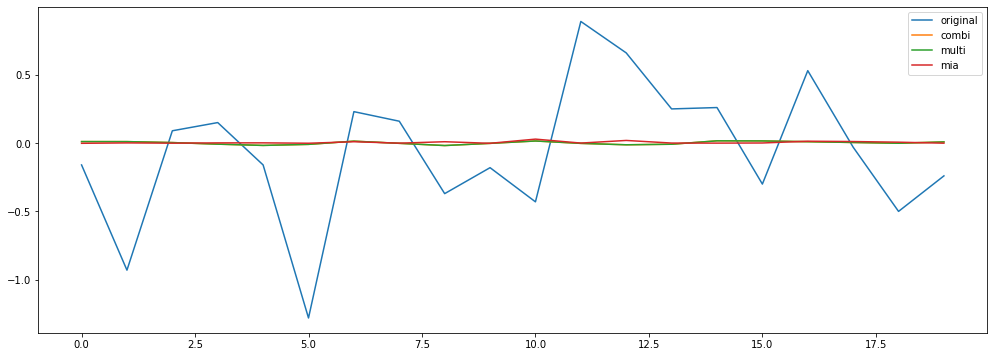

In [71]:
n = 20
plt.figure(figsize=(17, 6))
sns.lineplot(x=np.arange(n), y=splited_data.y_test[:n], label='original');
sns.lineplot(x=np.arange(n), y=y_pred_combi[:n], label='combi');
sns.lineplot(x=np.arange(n), y=y_pred_multi[:n], label='multi');
sns.lineplot(x=np.arange(n), y=y_pred_mia[:n], label='mia');
#sns.lineplot(x=np.arange(n), y=y_pred_lr_combi[:n], label='regr_combi');
#sns.lineplot(x=np.arange(n), y=y_pred_lr[:n], label='regr');

In [86]:
def stat(y_real, y_pred):
    print("right:", ((y_real * y_pred > 0)).sum())
    print("wrong:", ((y_real * y_pred < 0)).sum())
    print("zero:", ((y_real * y_pred == 0)).sum())

In [89]:
print()
stat(splited_data.y_test, y_pred_combi)

right: 10181
wrong: 9835
zero: 304


In [90]:
stat(splited_data.y_test, y_pred_multi)

right: 10181
wrong: 9835
zero: 304


In [91]:
stat(splited_data.y_test, y_pred_mia)

right: 10010
wrong: 10006
zero: 304
